# Analysis of Philadelphia Reflections Haiku

> # Question: how do the haiku cluster?

-----------------------------

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from os.path import expanduser

In [2]:
from sklearn.cluster                 import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer # combines counting and normalizing
from sklearn.pipeline                import Pipeline

from sklearn.metrics                 import silhouette_samples, silhouette_score

In [3]:
%matplotlib inline

#%qtconsole

### Read in the Philadelphia Reflections haiku

In [4]:
import os
data_folder = 'corpus_haiku'

# Note the use of read(); readlines() does not work

documents = [open(os.path.join(data_folder, filename)).read() 
             for filename in os.listdir(data_folder)]

Unsupervised Feature Selection
---

by choosing a relatively low **max_df** for the vectorizer we remove a majority of the frequently-occuring function words we used for authorship determination and the TF-IDF algorithm will identify the important words.



# Find the K with the best silhouette score and greatest separation   

for Various K values and distance metrics 

In [5]:
import matplotlib.cm as cm

# ========================= PARAMETERS =========================

kmeans_kwargs = dict(copy_x = False, # improve numerical accuracy
                     n_jobs = -1     # use all available cores
                    )

tfidf_kwargs  = dict(max_df      = 0.4,   # select only words that appear in
                                          # no more than 40% of the documents
                     stop_words  = 'english'
                    )

range_n_clusters = range(2,20+1) # K values

#metric  = 'euclidean'
#metric  = 'cityblock'
metric  = 'cosine'
#metric  = 'l1'
#metric  = 'l2'
#metric  = 'manhattan'

verbose = False        # print out lovely graphs and summary?

# ========================= PARAMETERS =========================

summary = []                     # list of results

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    vectorizer = TfidfVectorizer(**tfidf_kwargs)
    clusterer  = KMeans(n_clusters=n_clusters, random_state=10, **kmeans_kwargs)
    pipeline   = Pipeline([ ('tfidf',  vectorizer),
                            ('kmeans', clusterer)])
    
    pipeline.fit(documents)
    
    cluster_labels = pipeline.predict(documents)
    X              = pipeline.transform(documents)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    
    silhouette_avg = silhouette_score(X, cluster_labels, metric=metric)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric=metric)
    
    silhouette_avg_pos = np.array(sample_silhouette_values)[np.array(sample_silhouette_values)>0].mean()
    silhouette_avg_neg = np.array(sample_silhouette_values)[np.array(sample_silhouette_values)<0].mean()
    if np.isnan(silhouette_avg_pos): silhouette_avg_pos = 0
    if np.isnan(silhouette_avg_neg): silhouette_avg_neg = 0
        
    if verbose: print("For n_clusters = {} the average silhouette_score is : {:.4f}; pos:{:.4f}, neg:{:.4f}".\
                      format(n_clusters, silhouette_avg, silhouette_avg_pos, silhouette_avg_neg))
    summary.append((n_clusters, silhouette_avg, silhouette_avg_pos, silhouette_avg_neg))
    
    if verbose:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # ===============
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        if silhouette_avg_pos>0: ax1.axvline(x=silhouette_avg_pos, color="blue", linestyle="--")
        if silhouette_avg_neg<0: ax1.axvline(x=silhouette_avg_neg, color="blue", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        # ========
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d (metric=%s)" % (n_clusters,metric)),
                     fontsize=14, fontweight='bold')

        plt.show()

x_vals = [x[0] for x in summary]
y_avg  = [x[1] for x in summary]
y_pos  = [x[2] for x in summary]
y_neg  = [x[3] for x in summary]
if verbose:
    plt.plot(x_vals,y_avg, label='avg')
    plt.xlim([0,len(x_vals)+2])
    plt.axvline(x=np.argmax(y_avg)+2, color="red", linestyle="--")
    plt.title('Silhouette Scores by KMeans K value')
    plt.xlabel('KMeans K value')
    plt.ylabel('Silhoutette Score')
    plt.plot(x_vals,y_pos, label='pos', linestyle="--")
    # plt.plot(x_vals,y_neg)
    plt.legend(loc='best')
    plt.show()

print("The silhouette scores in descending order for metric = {}".format(metric))
import operator
ordered_summary = sorted(summary, key = operator.itemgetter(1), reverse=True)
for cnum, avg, _, _ in ordered_summary:
    print cnum, "\t", avg

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


The silhouette scores in descending order for metric = cosine
2 	0.848970196154
3 	0.806930242385
5 	0.738301152431
4 	0.736364293384
6 	0.727508882456
8 	0.719759729611
7 	0.716139927555
9 	0.71562733291
12 	0.705375793795
14 	0.705203316425
13 	0.701534842864
18 	0.683752829
20 	0.682600485264
19 	0.679222449718
11 	0.673489128659
10 	0.672596251047
16 	0.669573615169
17 	0.667909194446
15 	0.665960262768


# Fit using the top 60%-tile Silhouette-Average-Scored K valued clusters

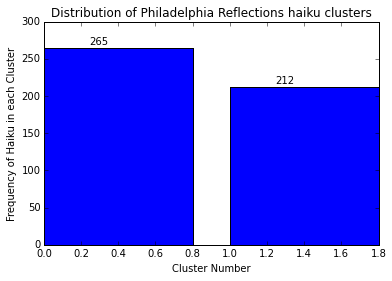


For cluster 0, 265 documents
1) time (score: 0.0155)
2) friends (score: 0.0153)
3) end (score: 0.0146)
4) life (score: 0.0141)
5) best (score: 0.0136)
Average cluster score 0.0146

For cluster 1, 212 documents
1) new (score: 0.0270)
2) old (score: 0.0225)
3) shout (score: 0.0217)
4) high (score: 0.0193)
5) fast (score: 0.0191)
Average cluster score 0.0219

The clusters by average score, descending
1 	0.0219447475182
0 	0.0146430109625
----------------------------------------------------------------


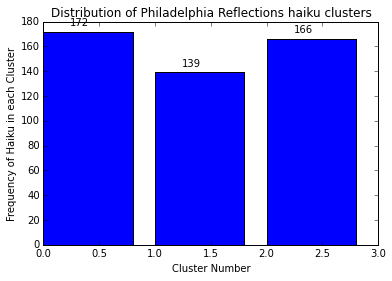


For cluster 0, 172 documents
1) stop (score: 0.0221)
2) words (score: 0.0173)
3) old (score: 0.0167)
4) eyes (score: 0.0160)
5) food (score: 0.0159)
Average cluster score 0.0176

For cluster 1, 139 documents
1) new (score: 0.0331)
2) change (score: 0.0245)
3) old (score: 0.0213)
4) prize (score: 0.0199)
5) way (score: 0.0196)
Average cluster score 0.0237

For cluster 2, 166 documents
1) time (score: 0.0234)
2) friends (score: 0.0222)
3) ends (score: 0.0212)
4) try (score: 0.0205)
5) best (score: 0.0173)
Average cluster score 0.0209

The clusters by average score, descending
1 	0.023660507073
2 	0.0209234752027
0 	0.0175982687144
----------------------------------------------------------------


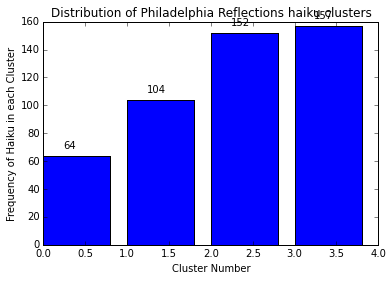


For cluster 0, 64 documents
1) like (score: 0.0309)
2) bite (score: 0.0234)
3) fresh (score: 0.0222)
4) wise (score: 0.0217)
5) words (score: 0.0195)
Average cluster score 0.0235

For cluster 1, 104 documents
1) check (score: 0.0407)
2) good (score: 0.0342)
3) win (score: 0.0241)
4) old (score: 0.0236)
5) new (score: 0.0222)
Average cluster score 0.0290

For cluster 2, 152 documents
1) time (score: 0.0267)
2) old (score: 0.0232)
3) age (score: 0.0229)
4) slow (score: 0.0212)
5) years (score: 0.0201)
Average cluster score 0.0228

For cluster 3, 157 documents
1) try (score: 0.0269)
2) cash (score: 0.0236)
3) shout (score: 0.0189)
4) stop (score: 0.0188)
5) turn (score: 0.0168)
Average cluster score 0.0210

The clusters by average score, descending
1 	0.0289506766664
0 	0.0235300188073
2 	0.0228195949642
3 	0.0209846782414
----------------------------------------------------------------


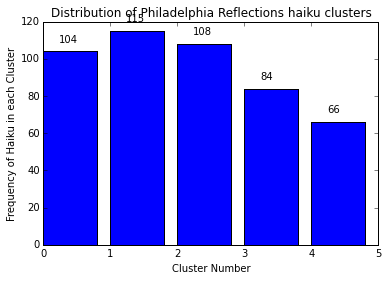


For cluster 0, 104 documents
1) years (score: 0.0292)
2) change (score: 0.0277)
3) old (score: 0.0261)
4) youth (score: 0.0248)
5) truth (score: 0.0212)
Average cluster score 0.0258

For cluster 1, 115 documents
1) game (score: 0.0332)
2) fans (score: 0.0254)
3) play (score: 0.0238)
4) win (score: 0.0218)
5) seek (score: 0.0198)
Average cluster score 0.0248

For cluster 2, 108 documents
1) old (score: 0.0270)
2) end (score: 0.0258)
3) young (score: 0.0207)
4) rich (score: 0.0193)
5) life (score: 0.0186)
Average cluster score 0.0223

For cluster 3, 84 documents
1) stop (score: 0.0396)
2) cash (score: 0.0370)
3) quick (score: 0.0282)
4) shout (score: 0.0243)
5) charge (score: 0.0224)
Average cluster score 0.0303

For cluster 4, 66 documents
1) wait (score: 0.0425)
2) voice (score: 0.0406)
3) choice (score: 0.0388)
4) don (score: 0.0278)
5) hear (score: 0.0234)
Average cluster score 0.0346

The clusters by average score, descending
4 	0.0346152674689
3 	0.030311436122
0 	0.0257990172278


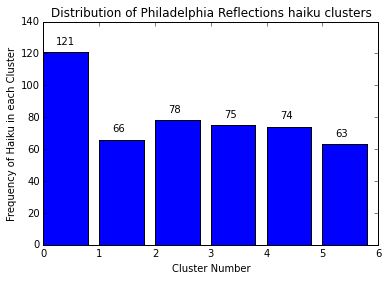


For cluster 0, 121 documents
1) win (score: 0.0310)
2) play (score: 0.0261)
3) game (score: 0.0222)
4) gold (score: 0.0202)
5) home (score: 0.0196)
Average cluster score 0.0238

For cluster 1, 66 documents
1) gals (score: 0.0321)
2) guys (score: 0.0295)
3) soon (score: 0.0279)
4) hot (score: 0.0244)
5) old (score: 0.0225)
Average cluster score 0.0273

For cluster 2, 78 documents
1) change (score: 0.0395)
2) time (score: 0.0319)
3) check (score: 0.0311)
4) day (score: 0.0233)
5) shift (score: 0.0224)
Average cluster score 0.0296

For cluster 3, 75 documents
1) old (score: 0.0365)
2) words (score: 0.0306)
3) slow (score: 0.0287)
4) sweet (score: 0.0249)
5) past (score: 0.0238)
Average cluster score 0.0289

For cluster 4, 74 documents
1) don (score: 0.0342)
2) head (score: 0.0299)
3) try (score: 0.0257)
4) choose (score: 0.0246)
5) cow (score: 0.0241)
Average cluster score 0.0277

For cluster 5, 63 documents
1) cash (score: 0.0353)
2) buy (score: 0.0289)
3) shout (score: 0.0284)
4) need 

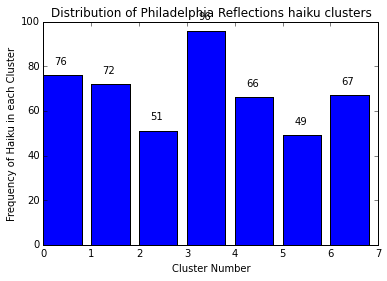


For cluster 0, 76 documents
1) head (score: 0.0402)
2) hide (score: 0.0318)
3) face (score: 0.0294)
4) turn (score: 0.0288)
5) smile (score: 0.0278)
Average cluster score 0.0316

For cluster 1, 72 documents
1) time (score: 0.0336)
2) ends (score: 0.0298)
3) shout (score: 0.0266)
4) dance (score: 0.0265)
5) old (score: 0.0224)
Average cluster score 0.0278

For cluster 2, 51 documents
1) buy (score: 0.0339)
2) prize (score: 0.0300)
3) wish (score: 0.0296)
4) boast (score: 0.0251)
5) win (score: 0.0221)
Average cluster score 0.0281

For cluster 3, 96 documents
1) wait (score: 0.0335)
2) end (score: 0.0252)
3) near (score: 0.0245)
4) free (score: 0.0237)
5) game (score: 0.0227)
Average cluster score 0.0259

For cluster 4, 66 documents
1) good (score: 0.0416)
2) old (score: 0.0404)
3) quick (score: 0.0386)
4) check (score: 0.0306)
5) new (score: 0.0245)
Average cluster score 0.0352

For cluster 5, 49 documents
1) stand (score: 0.0401)
2) loud (score: 0.0360)
3) words (score: 0.0303)
4) bea

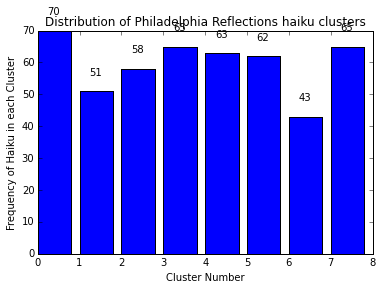


For cluster 0, 70 documents
1) change (score: 0.0376)
2) man (score: 0.0290)
3) time (score: 0.0285)
4) check (score: 0.0262)
5) day (score: 0.0245)
Average cluster score 0.0291

For cluster 1, 51 documents
1) game (score: 0.0420)
2) play (score: 0.0390)
3) best (score: 0.0358)
4) gals (score: 0.0353)
5) match (score: 0.0301)
Average cluster score 0.0364

For cluster 2, 58 documents
1) gone (score: 0.0335)
2) loud (score: 0.0277)
3) noise (score: 0.0254)
4) stay (score: 0.0242)
5) flee (score: 0.0234)
Average cluster score 0.0268

For cluster 3, 65 documents
1) years (score: 0.0393)
2) age (score: 0.0311)
3) days (score: 0.0297)
4) slow (score: 0.0277)
5) wait (score: 0.0258)
Average cluster score 0.0307

For cluster 4, 63 documents
1) choice (score: 0.0336)
2) voice (score: 0.0320)
3) old (score: 0.0316)
4) kids (score: 0.0257)
5) ll (score: 0.0246)
Average cluster score 0.0295

For cluster 5, 62 documents
1) try (score: 0.0366)
2) pride (score: 0.0325)
3) cool (score: 0.0320)
4) sho

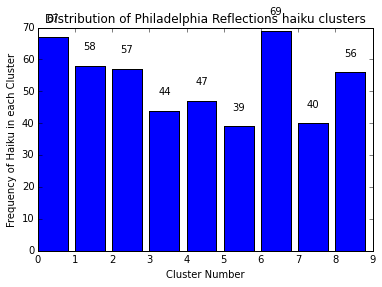


For cluster 0, 67 documents
1) hide (score: 0.0359)
2) pride (score: 0.0314)
3) cool (score: 0.0311)
4) words (score: 0.0289)
5) head (score: 0.0259)
Average cluster score 0.0306

For cluster 1, 58 documents
1) dance (score: 0.0327)
2) step (score: 0.0260)
3) watch (score: 0.0244)
4) craze (score: 0.0241)
5) feet (score: 0.0239)
Average cluster score 0.0262

For cluster 2, 57 documents
1) years (score: 0.0419)
2) age (score: 0.0404)
3) youth (score: 0.0363)
4) clocks (score: 0.0300)
5) young (score: 0.0295)
Average cluster score 0.0356

For cluster 3, 44 documents
1) checks (score: 0.0365)
2) seek (score: 0.0363)
3) game (score: 0.0331)
4) end (score: 0.0311)
5) fools (score: 0.0281)
Average cluster score 0.0330

For cluster 4, 47 documents
1) work (score: 0.0386)
2) fat (score: 0.0351)
3) waist (score: 0.0313)
4) just (score: 0.0311)
5) new (score: 0.0306)
Average cluster score 0.0333

For cluster 5, 39 documents
1) near (score: 0.0386)
2) stop (score: 0.0357)
3) blame (score: 0.0355

In [6]:
top_four = np.where(y_avg>np.percentile(y_avg,60))[0]+2

for n_clusters in top_four:

    pipe = Pipeline( [('vec',    TfidfVectorizer(**tfidf_kwargs)),
                      ('kmeans', KMeans(n_clusters=n_clusters, **kmeans_kwargs))])

    pipe.fit(documents)
    labels = pipe.predict(documents)
    
    # how many documents in each cluster?
    # ===================================
    from collections import Counter
    c = Counter(labels)

    plt.bar(c.keys(),c.values())

    plt.title('Distribution of Philadelphia Reflections haiku clusters')
    plt.xlabel('Cluster Number')
    plt.ylabel('Frequency of Haiku in each Cluster')

    for k,v in c.iteritems():
        plt.text(k+0.25,v+5,v)

    plt.show()
    
    # get the term list extracted by Tfidfvectorizer
    # ==============================================
    terms = pipe.named_steps['vec'].get_feature_names()
    
    # find the five most-important terms in each cluster
    # ==================================================
    cluster_avg5_scores = []
    for cluster_number in range(n_clusters):
        print("\nFor cluster {}, {:,} documents".format(cluster_number, c[cluster_number]))
        centroid = pipe.named_steps['kmeans'].cluster_centers_[cluster_number]
        most_important = centroid.argsort()
        total_score = 0
        for i in range(5):
            term_index = most_important[-(i+1)]
            total_score += centroid[term_index]
            print("{}) {} (score: {:.4f})".\
                  format(i+1, terms[term_index].encode('utf-8'), centroid[term_index]))
        print("Average cluster score {:.4f}".format(total_score/5.0))
        cluster_avg5_scores.append((cluster_number, total_score/5.0))
        
    print("\nThe clusters by average score, descending")
    import operator
    cluster_avg5_scores.sort(key = operator.itemgetter(1), reverse=True)
    for cnum, avg in cluster_avg5_scores:
        print cnum, "\t", avg
    print('----------------------------------------------------------------')
    